# Rossmann Store Sales Prediction
### Contributors : 
Niklas Hübel, Wrijupan Bhattacharyya, Magdalena Blum-Oeste

### Task

The task of this notebook is to predict the Store sales of Rossmann. It was developed for a mini-competition for the Data Science Retreat bootcamp.

The Sales are effected by various factors including whether a Promo is currently ongoing, number of Customers, competitors nearby, holidays etc.

### Table of contents

The following topics will be covered in this project:
#### 1. Data importing
#### 2. Exploratory data analysis (put notebook link>)
#### 3. Dealing with missing values
#### 4. Removal of outliers
#### 5. Feature engineering
#### 6. Feature selection and scaling
#### 7. Model building
    A. Lasso Regression
    B. Random Forest
    C. XGBoost
#### 8. Model evaluation

# Import libraries

In [1]:
import pandas as pd
import numpy as np

from collections import Counter
import holidays
import sys


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Append path for importing the helper function
# from inside the 'src' directory
#sys.path += ['./feature_extraction', './utils', '../src']
sys.path += ['../src']
from feature_engineering import *
from feature_scaling import *
from outliers import *
from utils import *
from helperFunctions import *

# 1. Load input data
## 1.1 Load and merge data

In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/holdout.csv")

store = pd.read_csv("../data/store.csv")
data_train = pd.merge(store, train, on='Store', how='left')
data_test = pd.merge(store, train, on='Store', how='left')

/Users/apple/miniconda3/envs/cta-dev/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## 1.2 Convert 'Date' column and generate generic date features


In [4]:
data_train.loc[:, 'Date'] = pd.to_datetime(data_train.loc[:, 'Date'])
data_train.loc[:, 'Month'] = data_train['Date'].dt.month
data_train.loc[:, 'DayOfMonth'] = data_train['Date'].dt.day
data_train.loc[:, 'Year'] = data_train['Date'].dt.year
data_train.loc[:, 'DayOfWeek'] = data_train['Date'].dt.dayofweek
data_train.loc[:, 'WeekOfYear'] = data_train['Date'].dt.weekofyear

data_test.loc[:, 'Date'] = pd.to_datetime(data_test.loc[:, 'Date'])
data_test.loc[:, 'Month'] = data_test['Date'].dt.month
data_test.loc[:,'DayOfMonth'] = data_test['Date'].dt.day
data_test.loc[:,'Year'] = data_test['Date'].dt.year
data_test.loc[:,'DayOfWeek'] = data_test['Date'].dt.dayofweek
data_test.loc[:,'WeekOfYear'] = data_test['Date'].dt.weekofyear

## 1.3 Drop rows based on 'Sales' column 
#### Drop rows with value zero

In [5]:
zero_sales = data_train.Sales == 0
data_train = data_train.loc[~zero_sales]
print(f'Drop {sum(zero_sales)} rows, keep {data_train.shape[0]}')

zero_sales = data_test.Sales == 0
missing_sales = data_test.Sales.isnull()
data_test = data_test.loc[~(zero_sales|missing_sales)]
print(f'Drop {sum(zero_sales|missing_sales)} rows, keep {data_test.shape[0]}')

Drop 102652 rows, keep 515821
Drop 121097 rows, keep 497376


## 1.4 Remove erroneous data
#### Drop row with nonzero sales despite being closed

In [6]:
data_train = closed_sales(data_train)
data_test = closed_sales(data_train)

## 1.5 Compute 'Sales_per_customer' column
#### Compute sales per customer for each store from training set data

In [7]:
group = data_train.groupby(by='Store').agg({'Sales': 'mean', 'Customers': 'mean'})
group['Sales_per_customer'] = group['Sales'] / group['Customers']

#### Map sales per customer to training and test set

In [8]:
data_train['Sales_per_customer'] = data_train['Store'].map(group['Sales_per_customer'])
data_test['Sales_per_customer'] = data_test['Store'].map(group['Sales_per_customer'])

## 1.6 Compute 'Customers_per_store' column
#### Compute customers per store for each store from training set data

In [9]:
group = data_train.groupby('Store').agg({'Customers': 'mean'})

#### Map customers per store to training and test set

In [10]:
data_train['Customer_per_store'] = data_train['Store'].map(group['Customers'])
data_test['Customer_per_store'] = data_test['Store'].map(group['Customers'])

# 2. Missing value imputation
#### Overview before imputing missing values

In [11]:
missing_report(data_train, pd)

,Null (total),Null (percent),Type
Store,0,0.00,int64
StoreType,0,0.00,object
Assortment,0,0.00,object
CompetitionDistance,1351,0.26,float64
CompetitionOpenSinceMonth,162948,31.77,float64
CompetitionOpenSinceYear,162948,31.77,float64
Promo2,0,0.00,int64
Promo2SinceWeek,252634,49.26,float64
Promo2SinceYear,252634,49.26,float64
PromoInterval,252634,49.26,object


## 2.1 'Promo', 'Promo2'
#### Drop all null values

In [12]:
missing_promo = data_train.Promo.isnull() | data_train.Promo2.isnull()
data_train = data_train.loc[~missing_promo, :]
print(f'Drop {sum(missing_promo)} rows, keep {data_train.shape[0]}')

missing_promo = data_test.Promo.isnull() | data_test.Promo2.isnull()
data_test = data_test.loc[~missing_promo, :]
print(f'Drop {sum(missing_promo)} rows, keep {data_test.shape[0]}')

Drop 15432 rows, keep 497396
Drop 15432 rows, keep 497396


## 2.2 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'
#### Apply mean imputation for missing values

In [13]:
data_train = mean_imputation(data_train,['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'])
data_test = mean_imputation(data_test,['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'])

## 2.3 'Promo2SinceWeek', 'Promo2SinceYear',  'PromoInterval'
#### Apply mean imputation for stores participating and constant imputation with zero for stores not participating

In [14]:
data_train = mean_imputation(data_train, ['Promo2SinceWeek', 'Promo2SinceYear'], enforce_int=True)
Promo2 = data_train.Promo2 == 1
data_train.loc[~Promo2, ['Promo2SinceWeek', 'Promo2SinceYear']] = 0
data_train = const_imputation(data_train,['PromoInterval'],values='unavailable')

data_test = mean_imputation(data_test, ['Promo2SinceWeek', 'Promo2SinceYear'], enforce_int=True)
Promo2 = data_test.Promo2 == 1
data_test.loc[~Promo2, ['Promo2SinceWeek', 'Promo2SinceYear']] = 0
data_test = const_imputation(data_test,['PromoInterval'],values='unavailable')

## 2.4 'Sales', 'Customers', 'Open'
#### Drop rows with missing 'Sales' in case 'Open' or 'Customers' is zero (training set only)

In [15]:
not_open = data_train.Open==0
no_customer = data_train.Customers==0
missing_sales = data_train.Sales.isnull()
data_train = data_train.loc[~((not_open | no_customer) & missing_sales), :]

print(f'Drop {sum(((not_open | no_customer) & missing_sales))} rows, keep {data_train.shape[0]}')

Drop 85 rows, keep 497311


#### Impute 'Sales' from 'Customers' and 'Sales_per_customer' (training set only)

In [16]:
missing_sales = data_train.Sales.isnull()
data_train.loc[missing_sales, 'Sales'] = data_train.loc[missing_sales, 'Customers'] * data_train.loc[missing_sales, 'Sales_per_customer']
missing_sales = data_train.Sales.isnull()
data_train = data_train.loc[~missing_sales, :]

print(f'Drop {sum(missing_sales)} rows, keep {data_train.shape[0]}')
data_train = const_imputation(data_train,['Open'],values=1)

Drop 451 rows, keep 496860


#### Drop rows with missing or zero 'Open' (test set only)

In [17]:
not_open = data_test.Open==0
missing_open = data_test.Open.isna()

data_test = data_test.loc[~(not_open | missing_open), :]

print(f'Drop {sum(not_open | missing_open)} rows, keep {data_test.shape[0]}')

Drop 15070 rows, keep 482326


## 2.5 'StateHoliday'
#### Look up if 'Date' is a national holiday and impute missing values with 'a' and '0' accordingly

In [18]:
data_train = holiday_imputation(data_train, holidays)
data_test = holiday_imputation(data_test, holidays)

## 2.6 'CompetitionDistance'
#### Drop rows with missing values

In [19]:
missing_distance = data_train.CompetitionDistance.isnull()
data_train = data_train.loc[~missing_distance, :]
print(f'Drop {sum(missing_distance)} rows, keep {data_train.shape[0]}')

missing_distance = data_test.CompetitionDistance.isnull()
data_test = data_test.loc[~missing_distance, :]
print(f'Drop {sum(missing_distance)} rows, keep {data_test.shape[0]}')

Drop 1299 rows, keep 495561
Drop 1246 rows, keep 481080


## 2.7 Drop columns 'Customers', 'Open' and 'SchoolHoliday'

In [20]:
data_train = data_train.drop(columns = ['Customers','Open', 'SchoolHoliday'])
data_test = data_test.drop(columns = ['Customers','Open', 'SchoolHoliday'])

In [21]:
missing_report(data_train, pd)

,Null (total),Null (percent),Type
Store,0,0.0,int64
StoreType,0,0.0,object
Assortment,0,0.0,object
CompetitionDistance,0,0.0,float64
CompetitionOpenSinceMonth,0,0.0,float64
CompetitionOpenSinceYear,0,0.0,float64
Promo2,0,0.0,int64
Promo2SinceWeek,0,0.0,float64
Promo2SinceYear,0,0.0,float64
PromoInterval,0,0.0,object


In [22]:
missing_report(data_test, pd)

,Null (total),Null (percent),Type
Store,0,0.0,int64
StoreType,0,0.0,object
Assortment,0,0.0,object
CompetitionDistance,0,0.0,float64
CompetitionOpenSinceMonth,0,0.0,float64
CompetitionOpenSinceYear,0,0.0,float64
Promo2,0,0.0,int64
Promo2SinceWeek,0,0.0,float64
Promo2SinceYear,0,0.0,float64
PromoInterval,0,0.0,object


# 3. Encoding of categorical variables
## 3.1 'Store'
#### Mean and frequency encoding

In [23]:
data_train, mean_values = mean_encoding(data_train, 'Store')
data_train, fenc_values = freq_encoding(data_train, 'Store')

data_test.loc[:, 'Store_menc'] = data_test['Store'].map(mean_values)
data_test.loc[:, 'Store_fenc'] = data_test['Store'].map(fenc_values)

## 3.2 'StoreType'
#### One hot encoding

In [24]:
data_train = pd.get_dummies(data_train, columns=['StoreType'], drop_first=True)
data_test = pd.get_dummies(data_test, columns=['StoreType'], drop_first=True)

## 3.3 'Assortment'
#### Ordinal encoding according to assortment levels: a = basic, b = extra, c = extended

In [25]:
data_train = ordinal_encoding(data_train, 'Assortment', {'a':1, 'b':2, 'c':3})
data_test = ordinal_encoding(data_test, 'Assortment', {'a':1, 'b':2, 'c':3})

## 3.4 'StateHoliday'
#### Binary encoding

In [26]:
data_train = binary_encoding(data_train, 'StateHoliday', positive_list=['a', 'b', 'c'])
data_test = binary_encoding(data_test, 'StateHoliday', positive_list=['a', 'b', 'c'])

## 3.5 Drop encoded columns and null values from test set

In [27]:
data_train = data_train.drop(columns=['Store', 'Assortment', 'StateHoliday'])
data_test = data_test.drop(columns=['Store', 'Assortment', 'StateHoliday'])
data_train = data_train.rename(columns={'Assortment_orenc': 'Assortment'})
data_test = data_test.rename(columns={'Assortment_orenc': 'Assortment'})
data_test = data_test.dropna()

# 4. Feature engineering
## 4.1 'CompetionOpenSincePeriod'

In [28]:
data_train = compet_openmonths(data_train, yr='CompetitionOpenSinceYear', mth='CompetitionOpenSinceMonth')
data_test = compet_openmonths(data_test, yr='CompetitionOpenSinceYear', mth='CompetitionOpenSinceMonth')

## 4.2 'Promo2Since'

In [29]:
data_train = promo_openweeks(data_train, yr='Promo2SinceYear', week='Promo2SinceWeek')
data_test = promo_openweeks(data_test, yr='Promo2SinceYear', week='Promo2SinceWeek')

# 5. Dealing with outliers

## 5.1 Removing outliers of the Sales 
Remove based on the 99 percentile of the Sales

In [30]:
# Drop only in the training set
data_train = drop_outlier(data_train, col='Sales', per=99)

## 5.2 Filter CompetitionOpenSinceYear 
There are some entries with competitors open since a long time back, for e.g. 1900. We hypothesize such a distant opening will not affect the Sales. Hence we drop those extreme values.

In [31]:
data_train = comp_outliers(data_train, yr='CompetitionOpenSinceYear')
data_test = comp_outliers(data_test, yr='CompetitionOpenSinceYear')

# 6. Split features and target
Train the model on the features and target of the data_train.

Use the trained model later to predict the target for the data_test and evaluate the metric.

In [32]:
# Training set
X_train = data_train.drop(columns='Sales')
y_train = data_train['Sales']

In [33]:
# Holdout set
X_test = data_test.drop(columns='Sales')
y_test = data_test['Sales']

# 7. Feature scaling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1133ee6d0>,
      dtype=object)

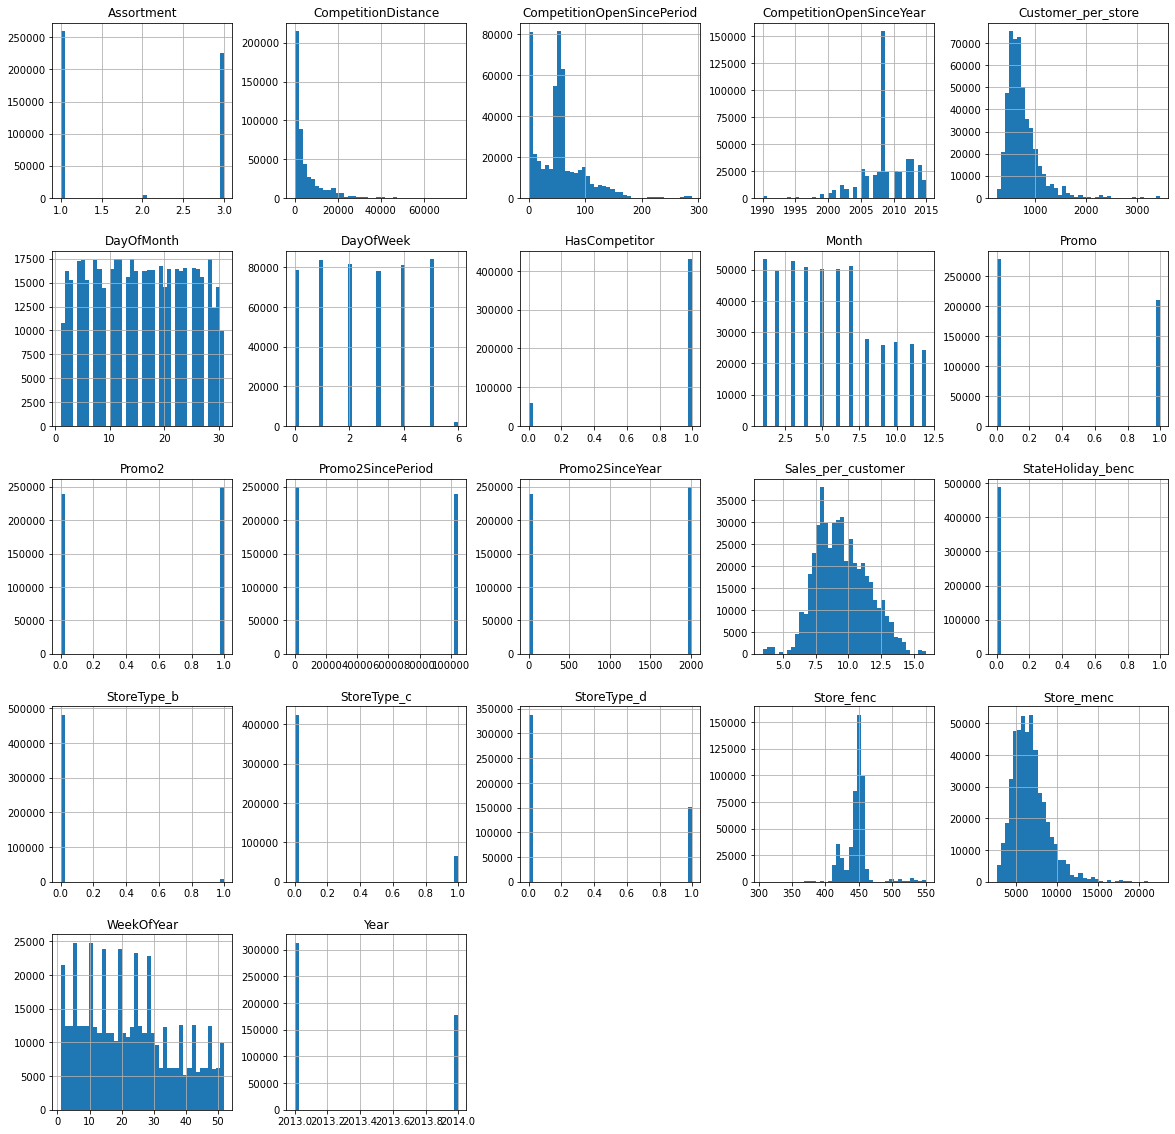

In [34]:
X_train.hist(figsize=[20,20], bins=40)

##### Feature selection

The following features will be used in building the model

In [35]:
my_features = ['Sales_per_customer', 'CompetitionDistance', 'Customer_per_store', 
               'Store_menc', 'CompetitionOpenSincePeriod', 
               'Month', 'Year', 'DayOfWeek', 'WeekOfYear', 'DayOfMonth', 
               'StoreType_b', 'StoreType_c', 'StoreType_d', 
               'Promo2SincePeriod', 'Promo2', 'Promo', 
               'HasCompetitor', 
               'Assortment',]

From the feature distribution we can tell that most of the features do not have a Gaussian distribution. We use three methods of scaling:
1. StandardScaler() : When the feature is Gaussian-like
2. MinMaxScaler() : If the feature distribution is unknown or feature is non-Gaussian
3. RobustScaler() : We use this to scale features which might have some outliers

To achieve the feature selection and scaling we now make use of two helper functions (under 'src'):
1. feature_selector: this function selects the features for Standard scaling, Minmax scaling or Robust scaling
2. feature_transformer: This function returns a ColumnTransformer object from scikit-learn. The transformer applies the appropriate scaling methods to the different subsets of columns

In [36]:
# This just returns list of column names for different scaling methods
# for e.g. minmax_cols: columns to apply minmax scaling, and so on for the others
minmax_cols, rob_cols, std_cols = feature_selector(my_features)

In [37]:
# This is the Column transformer object 'ct' that takes as input the 
# list of columns from the step before
ct = feature_transformer(minmax_cols, rob_cols, std_cols)

# 8. Model building
The models are:
1. Random Forest
2. Lasso Regression
3. XGBoost

The parameters used in the final model is a best result of GridSearch over a wider parameter space

### Random Forest

In [ ]:
# Define the model parameters
rf = RandomForestRegressor(n_estimators=150, 
                           criterion='mse', 
                           max_depth=4,
                           min_samples_leaf=2,
                           random_state=42)

#pca = PCA(n_components=2)

# Implement the steps for the sklearn's Pipeline object
# Steps: Scaling and model fitting
steps_rf = [('scaler', ct), ('rf', rf)]

# Define the Pipeline object
pipe_rf = Pipeline(steps_rf)

# Fit the model
pipe_rf.fit(X_train.loc[:, my_features], y_train)

### Lasso

In [ ]:
# Define the model parameters
lasso = Lasso(alpha=0.1)

# Implement the steps for the sklearn's Pipeline object
# Steps: Scaling and model fitting
steps_las = [('scaler', ct), ('lasso', lasso)]

# Define the Pipeline object
pipe_las = Pipeline(steps_las)

# Fit the model
pipe_las.fit(X_train.loc[:, my_features], y_train)

### XGBoost

In [ ]:
# Define the model parameters
xgbreg = xgb.XGBRegressor(random_state=42, 
                          objective='reg:squarederror', 
                          booster='gbtree', 
                          gamma=0.01, 
                          learning_rate=0.1, 
                          max_depth=5, 
                          n_estimators=150, 
                          reg_alpha=63.09, 
                          reg_lambda=0.25)


# Implement the steps for the sklearn's Pipeline object
# Steps: Scaling and model fitting
steps_xgb = [('scaler', ct), ('xgb', xgbreg)]

# Define the Pipeline object
pipe_xgb = Pipeline(steps_xgb)

# Fit the model
pipe_xgb.fit(X_train.loc[:, my_features], y_train)

### Voting regressor
We ensemble our model under one model using sklearn's VotingRegressor.

It averages the prediction from the individual base estimators.

In [ ]:
# Define the models
lin_model = lasso
tree_model = rf
boost_model = xgbreg

regressors = [('linear', lin_model), 
              ('rf', tree_model), 
              ('xgb', boost_model)]

vr = VotingRegressor(estimators = regressors)

# # Implement the steps for the sklearn's Pipeline object
# Steps: Scaling and model fitting
steps_vr = [('scaler', ct), ('vote', vr)]


# Define the Pipeline object
pipe_vr = Pipeline(steps_vr)

# Fit the model
pipe_vr.fit(X_train.loc[:, my_features], y_train)

# 9. Model evaluation

For the model evaluation we used a separate holdout dataset.

The metric used for evaluation is root mean square percentage error (RMSPE)

In [ ]:
# Evaluation metric
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

#### Evaluate the Random Forest model

In [ ]:
y_pred_rf = pipe_rf.predict(X_test.loc[:, my_features])

rf_base_metric = metric(y_pred_rf, y_test.values)

print("Metric for RandomForest prediction = {}".format(rf_base_metric))

#### Evaluate the Lasso model

In [ ]:
y_pred_las = pipe_las.predict(X_test.loc[:, my_features])

las_base_metric = metric(y_pred_las, y_test.values)

print("Metric for Lasso prediction = {}".format(las_base_metric))

#### Evaluate the XGBoost model

In [ ]:
y_pred_xgb = pipe_xgb.predict(X_test.loc[:, my_features])

xgb_base_metric = metric(y_pred_xgb, y_test.values)

print("Metric for XGBoost prediction = {}".format(xgb_base_metric))

#### Evaluate the VotinRegressor

In [ ]:
y_pred_vr = pipe_vr.predict(X_test.loc[:, my_features])

vr_base_metric = metric(y_pred_vr, y_test.values)

print("Metric for RandomForest prediction = {}".format(vr_base_metric))

# 10. Conclusions

1. After trying out different staretgies for data preprocessing and model building, we evaluate our predictions for Rossmann stores sales on a separate holdout data set. The model which provides the best root means square percentage error is XGBoost. The values of the metric are compared in the table below-

|Model     |   RMSPE   | 
|---------|-----------------|
| XGBoost Regressor | 21.85 |
| Voting Regressor | 25.59 |
| Lasso Regressor | 27.79 |
| Random Forest Regressor| 30.45 |

2. Of course there is room for further improvement by trying other data cleaning, feature engineering methods as well as other Machine learning models